### Portfolio Diversification using K-Means

This work presents an approach to using the K-means algorithm for stock classification, with the aim of helping investors to diversify their investment portfolios Clustering of S&P 500 stocks by return and volatility.

In [33]:
#Import the libraries that we are going to need to carry out the analysis:
import numpy as np 
import pandas as pd
import pandas_datareader as dr
import yfinance as yf

from pylab import plot,show
from matplotlib import pyplot as plt
import plotly.express as px

from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn.cluster import KMeans 
from sklearn import preprocessing

In [34]:
# Define the url
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].values.tolist()
tickers = [s.replace('\n', '') for s in tickers]
tickers = [s.replace('.', '-') for s in tickers]
tickers = [s.replace(' ', '') for s in tickers]

In [35]:
# Download prices
prices_list = []
for ticker in tickers:
    try:
        prices = yf.download(ticker,'2020-01-01','2022-12-02')['Adj Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)
prices_df.sort_index(inplace=True)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1669957200")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1669957200")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [36]:
# Remove columns with Null values
prices_df.dropna(axis=1, inplace=True)

# Print the DataFrame
print(prices_df)

                   MMM        AOS         ABT        ABBV         ACN  \
Date                                                                    
2020-01-02  154.553284  44.557995   81.730186   75.656311  199.225388   
2020-01-03  153.222412  44.166229   80.733833   74.938187  198.893600   
2020-01-06  153.368362  44.446072   81.156815   75.529587  197.594803   
2020-01-07  152.750168  44.147591   80.705627   75.098701  193.328751   
2020-01-08  155.094223  44.082291   81.034615   75.630966  193.707932   
...                ...        ...         ...         ...         ...   
2022-11-25  123.598480  61.029469  105.442719  154.957718  292.974579   
2022-11-28  119.384026  58.957664  103.894997  153.802475  287.241608   
2022-11-29  120.811195  59.677864  103.510529  153.579208  284.651917   
2022-11-30  120.657951  59.924511  106.053932  156.472168  297.452240   
2022-12-01  120.677101  59.667995  106.398964  156.909012  299.330261   

                 ATVI        ADM        ADBE      

In [37]:
prices_df.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AES,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00,154.553284,44.557995,81.730186,75.656311,199.225388,57.028183,42.027317,334.429993,157.518600,17.999643,...,194.497040,326.561279,141.707474,56.082607,76.319847,95.391968,259.140015,141.097351,46.221893,130.801041
2020-01-03 00:00:00,153.222412,44.166229,80.733833,74.938187,198.893600,57.047623,41.945286,331.809998,157.185654,17.792957,...,194.544662,322.724518,139.605545,56.352322,76.769066,95.093201,256.049988,140.728500,45.569641,130.820511
2020-01-06 00:00:00,153.368362,44.446072,81.156815,75.529587,197.594803,58.088039,41.617168,333.709991,157.398422,17.999643,...,194.782669,319.721436,139.329239,56.271412,76.272057,95.037201,258.010010,139.915176,45.014343,129.816162
2020-01-07 00:00:00,152.750168,44.147591,80.705627,75.098701,193.328751,58.671448,41.115860,333.390015,155.493210,18.062544,...,194.382797,320.053040,139.990417,56.154530,75.985313,95.205238,256.470001,139.792267,44.741108,130.254959
2020-01-08 00:00:00,155.094223,44.082291,81.034615,75.630966,193.707932,58.224171,40.660137,337.869995,156.954437,18.026602,...,194.601776,323.435120,140.868683,56.100590,76.243385,95.373306,247.639999,141.466156,45.181805,129.972183


In [38]:
# Create an empity dataframe
returns = pd.DataFrame()

# Define the column Returns
returns['Returns'] = prices_df.pct_change().mean() * 252

# Define the column Volatility
returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)

#### Determine the optimal number of clusters

The Elbow curve method is a technique used to determine the optimal number of clusters for K-means clustering. The method works by plotting the sum of squared errors (SSE) for different values of k (number of clusters). The optimal number of clusters is the value of k at which the SSE starts to decrease at a slower rate. The optimal number of clusters is determined by finding the elbow or the point at which the SSE reaches its minimum value. In this case, the optimal number of clusters is 4.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

Text(0.5, 1.0, 'Elbow curve')

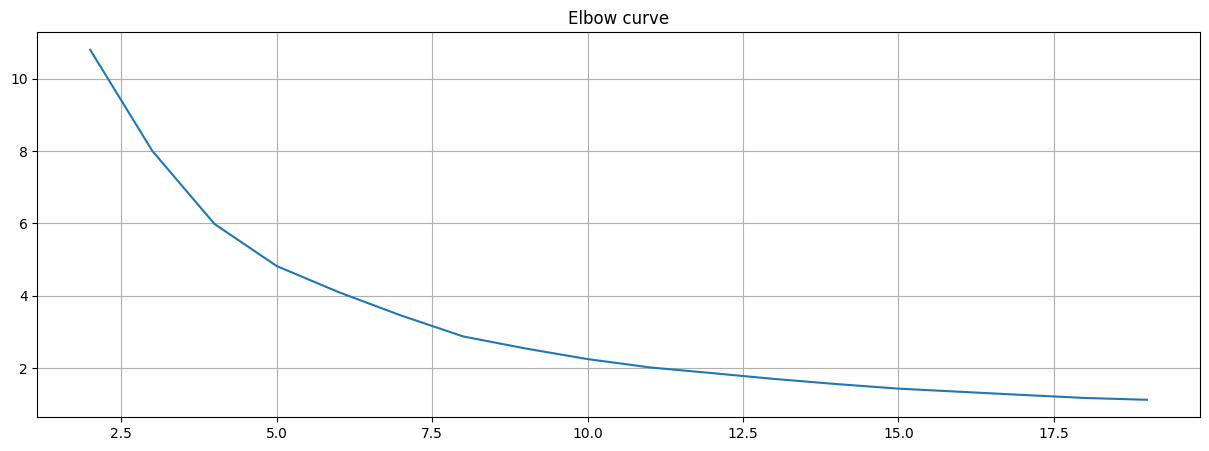

In [39]:
# Format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))

plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

#### K-means clustering

Once the optimum number of clusters has been defined, we proceed to create them. In the first instance, the centroids are defined using the sklearn library. For the creation of 4 groups of actions, the K-means algorithm iteratively assigns data points to the groups based on their similarity of characteristics, or “features”, in this case, Average Annualized Return and Average Annualized Volatility.

In [40]:
# Computing K-Means with K = 4 (4 clusters)
centroids,_ = kmeans(data,4)

# Assign each sample to a cluster
idx,_ = vq(data,centroids)

# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ['Ticker','Cluster']

# Create another dataframe with the tickers and data from each stock
clusters_df = returns.reset_index()

# Bring the clusters information from the dataframe 'details_df'
clusters_df['Cluster'] = details_df['Cluster']

# Rename columns
clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']

In [41]:
# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
fig.update(layout_coloraxis_showscale=False)
fig.show()

#### Outlier Treatment

hen creating the clusters, four outliers or outliers are detected in a scatter plot. Outliers are data points that are significantly different from the rest of the data points in the data set. Often, they can lead to inaccurate results when using an algorithm, since they don’t fit the same pattern as the other data points. Therefore, it is important to segregate and remove outliers to improve the accuracy of the model.

Outlier removal can help the algorithm focus on the most representative data points and reduce the effect of outliers on the results. This can help increase the accuracy of the model and ensure that the data points are grouped correctly. The removed tickers are:

1. MRNA
2. ENPH
3. TSLA


In [42]:
# Identify and remove the outliers stocks
returns.drop('MRNA',inplace=True)
returns.drop('ENPH',inplace=True)
returns.drop('TSLA',inplace=True)

# Recreate data to feed into the algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

In [43]:
# Computing K-Means with K = 4 (4 clusters)
centroids,_ = kmeans(data,4)

# Assign each sample to a cluster
idx,_ = vq(data,centroids)

# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ['Ticker','Cluster']

# Create another dataframe with the tickers and data from each stock
clusters_df = returns.reset_index()

# Bring the clusters information from the dataframe 'details_df'
clusters_df['Cluster'] = details_df['Cluster']

# Rename columns
clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']

# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
fig.update(layout_coloraxis_showscale=False)
fig.show()

The graph shows 4 clusters that were generated using a K-means algorithm with 2 variables: average annualized return and average annualized volatility. These variables are used to measure the risk and return of a stock. The 4 clusters represent 4 groups of actions with different levels of risk and return in the period under study.

Clustering is useful for identifying peer groups among stocks, thus allowing differentiation between stocks with different levels of risk and return. This is useful for investors looking to diversify their investment portfolios, as it allows them to identify groups of stocks with different levels of risk and return.

Investors could use the 4 clusters to select a mix of stocks with different levels of risk and return based on their investment objectives. This will help them diversify their portfolio and reduce the risk of their investment since they will be investing in a variety of assets with different levels of risk.